<a href="https://colab.research.google.com/github/davidms22/UFV_Visualizacion/blob/main/Ejercicios%20Clase%20/Clase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **EJERCICIO CLASE 18/10/2024.**

**INTRODUCCIÓN.**

En este trabajo realizaremos un análisis de una base de datos de ventas llamada *'datos_ejercicio_ventas.csv'*. Usando Python y la biblioteca Plotly Express para la visualización, responderemos tres preguntas clave:

- **Distribución de ventas:** Analizar cómo se distribuyen las ventas según el país, mes/año y marca para identificar patrones de comportamiento.

- **Tendencias y estacionalidad:** Examinar la evolución de las ventas en el país con menor volumen y en la marca con mayores ventas, identificando tendencias y estacionalidades.

- **Evaluación de predicciones:** Revisar la precisión de las proyecciones de ventas en España, comparándolas con los datos reales.

Este trabajo ofrece una visión clara de los datos para facilitar decisiones.

**EXPLORACIÓN DE VARIABLES.**

En primer lugar, abrimos la base de datos con excel para poder observarla y entenderla. En este caso debemos aprovechar que es de un tamaño razonable para entenderla al completo.

- **COUNTRY**: País donde se registran las ventas.
- **SUBBRAND**: Submarca del producto involucrado en las ventas.
- **YEAR**: Año del registro de ventas o predicciones.
- **MONTH**: Mes correspondiente al registro.
- **SCENARIO**: Indicador de observacion real o predicha con AI.
- **FORECAST**: Código que identifica la predicción realizada (ej. "AI_P02F").
- **FORECAST_YEAR**: Año asociado a la predicción.
- **AMOUNT**: Valor numérico que representa el monto de ventas en unidades.

In [98]:
# Importamos librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')

In [99]:
# Cargamos los datos y mostrar la información básica
df = pd.read_csv('datos_ejercicio_ventas.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18666 entries, 0 to 18665
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   COUNTRY        18666 non-null  object 
 1   SUBBRAND       18666 non-null  object 
 2   YEAR           18666 non-null  int64  
 3   MONTH          18666 non-null  int64  
 4   SCENARIO       18666 non-null  object 
 5   FORECAST       17766 non-null  object 
 6   FORECAST_YEAR  17766 non-null  float64
 7   AMOUNT         18666 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.1+ MB
None
         COUNTRY        SUBBRAND  YEAR  MONTH     SCENARIO FORECAST  \
0       Portugal     Lipton (L3)  2023     12  AI_forecast  AI_P02F   
1  Great Britain     Lipton (L3)  2023     12  AI_forecast  AI_P10F   
2          Spain  Pepsi Max (L3)  2023     12  AI_forecast  AI_P09F   
3  Great Britain        7up (L3)  2024     12  AI_forecast  AI_P10F   
4        Hungary     Lipton (L

Al ver la primera fila, podemos hacer el ejercicio de traducirla al lenguaje y comprobar si hemos entendido la base de datos.

**En este caso**: en enero de 2023, se realizó una prediccion con IA para obtener la cantidad de Lipton vendido en Portugal durante el mes de diciembre de 2023.

**PREPARACIÓN DE LA BASE DE DATOS.**

Para continuar con el análisis, es importante asegurarnos de que el conjunto de datos esté libre de valores negativos o repetidos que puedan afectar los resultados.

In [100]:
# Mostramos el número de filas originales.
print("Número de filas original:", df.shape[0])

# Eliminamos filas con valores negativos en la columna 'AMOUNT'.
df = df[df['AMOUNT'] >= 0]

# Eliminamos filas duplicadas.
num_duplicadas = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicadas}")
df_sin_duplicados = df.drop_duplicates()
df.drop_duplicates(inplace=True)

# Mostramos el número de filas después de la limpieza.
print("Número de filas después de la limpieza:", df.shape[0])

# Vista de los datos después de la limpieza.
print(df.head())

Número de filas original: 18666
Número de filas duplicadas: 663
Número de filas después de la limpieza: 17993
         COUNTRY        SUBBRAND  YEAR  MONTH     SCENARIO FORECAST  \
0       Portugal     Lipton (L3)  2023     12  AI_forecast  AI_P02F   
1  Great Britain     Lipton (L3)  2023     12  AI_forecast  AI_P10F   
2          Spain  Pepsi Max (L3)  2023     12  AI_forecast  AI_P09F   
3  Great Britain        7up (L3)  2024     12  AI_forecast  AI_P10F   
4        Hungary     Lipton (L3)  2023      9  AI_forecast  AI_P03F   

   FORECAST_YEAR         AMOUNT  
0         2023.0  754356.237194  
1         2023.0  560030.558029  
2         2023.0   88501.980847  
3         2023.0  363224.511516  
4         2023.0  396176.120491  


In [101]:
# Mapeo de códigos de mes para FORECAST
mapeo_forecast = {
    "AI_P02F": "enero",
    "AI_P03F": "febrero",
    "AI_P04F": "marzo",
    "AI_P05F": "abril",
    "AI_P06F": "mayo",
    "AI_P07F": "junio",
    "AI_P08F": "julio",
    "AI_P09F": "agosto",
    "AI_P10F": "septiembre",
    "AI_P11F": "octubre",
    "AI_P12F": "noviembre",
    "AI_PF": "diciembre"
}
df['FORECAST'] = df['FORECAST'].replace(mapeo_forecast)

Ahora, estudiaremos la cantidad de valores nulos que tiene la base de datos así como la distribución que tiene de valores reales ('actuals') y predicciones ('FORECAST').

In [102]:
# Contamos el número de valores NaN en cada columna
nans_count = df.isnull().sum()
print("Conteo de valores nulos en cada columna:")
print(nans_count)

Conteo de valores nulos en cada columna:
COUNTRY            0
SUBBRAND           0
YEAR               0
MONTH              0
SCENARIO           0
FORECAST         890
FORECAST_YEAR    890
AMOUNT             0
dtype: int64


Como podemos observar, hay 900 NaNs en 'FORECAST' y 'FORECAST_YEAR', que representan las 900 observaciones las cuales no son predicciones si no valores reales.


Conteo de 'Forecast' y 'Actual' (incluyendo NaNs):
SCENARIO
AI_forecast    17103
actual           890
Name: count, dtype: int64


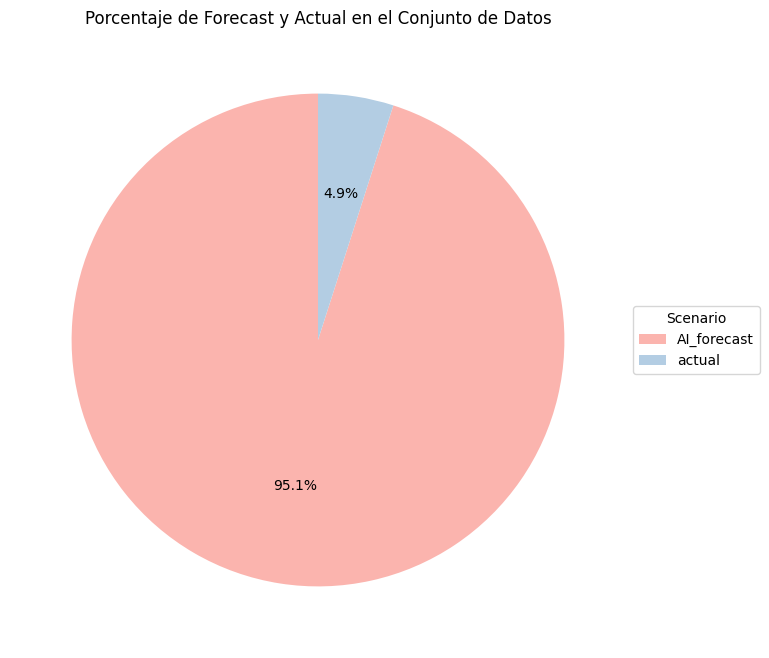

In [103]:
# Filtramos la columna 'SCENARIO' y contamos los valores de Forecast y Actual
scenario_counts = df['SCENARIO'].value_counts(dropna=False)
print("\nConteo de 'Forecast' y 'Actual' (incluyendo NaNs):")
print(scenario_counts)

# Creamos un DataFrame para el gráfico con el porcentaje de cada categoría
scenario_percentages = (scenario_counts / len(df)) * 100
scenario_df = scenario_percentages.reset_index()
scenario_df.columns = ['Scenario', 'Percentage']

# Datos para el gráfico de tarta
labels = scenario_df['Scenario']
sizes = scenario_df['Percentage']

# Creamos el gráfico de tarta
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Pastel1.colors
)

plt.legend(labels, title="Scenario", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Porcentaje de Forecast y Actual en el Conjunto de Datos')
plt.show()

Además, podemos ver como el 95.1% son predicciones y resto son valores reales.

Para continuar explorando la base de datos, veremos cuantos paises hay cuales son exactamente así como los productos en venta. Además, es importante saber el volumen de datos que hay de cada uno de los mencionados anteriormente.

In [104]:
# Identificamos los países únicos y contar cuántos hay
countries = df['COUNTRY'].unique()
num_countries = len(countries)
print(f"Número de países: {num_countries}")
print("Países:", countries)

# Identificamos las bebidas únicas y contar cuántas hay
subbrands = df['SUBBRAND'].unique()
num_subbrands = len(subbrands)
print(f"Número de bebidas (submarcas): {num_subbrands}")
print("Bebidas (Submarcas):", subbrands)

Número de países: 9
Países: ['Portugal' 'Great Britain' 'Spain' 'Hungary' 'Norway' 'Denmark'
 'Netherlands' 'Italy' 'Czech']
Número de bebidas (submarcas): 6
Bebidas (Submarcas): ['Lipton (L3)' 'Pepsi Max (L3)' '7up (L3)' 'Pepsi Regular (L3)'
 'Mountain Dew (L3)' '7up Free (L3)']


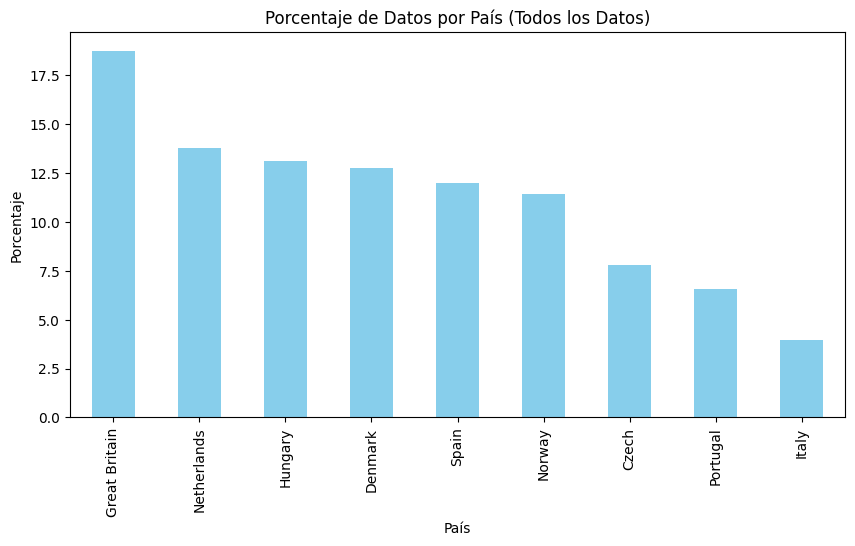

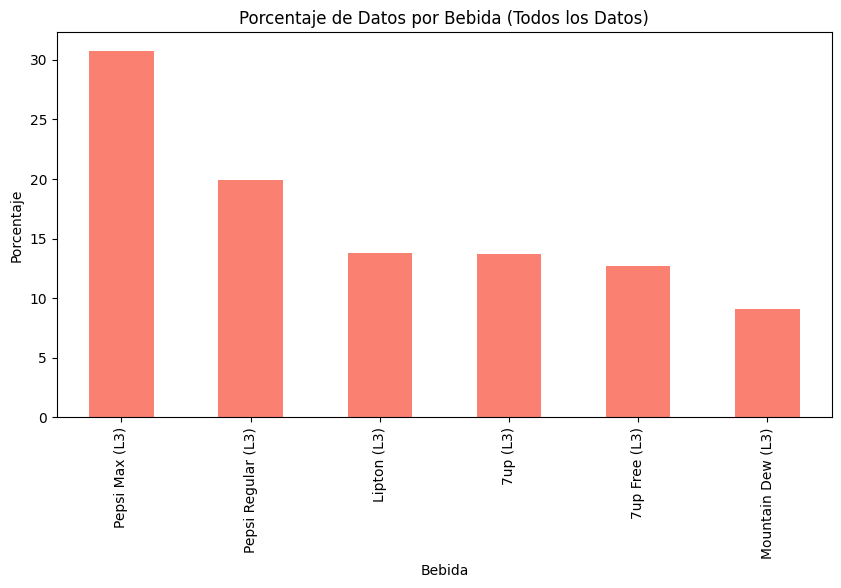

In [105]:
# Calculamos el porcentaje de datos para cada país y bebida
country_counts = df['COUNTRY'].value_counts(normalize=True) * 100
subbrand_counts = df['SUBBRAND'].value_counts(normalize=True) * 100

# Gráfico de barras para el porcentaje de datos por país
plt.figure(figsize=(10, 5))
country_counts.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de Datos por País (Todos los Datos)')
plt.ylabel('Porcentaje')
plt.xlabel('País')
plt.show()

# Gráfico de barras para el porcentaje de datos por bebida
plt.figure(figsize=(10, 5))
subbrand_counts.plot(kind='bar', color='salmon')
plt.title('Porcentaje de Datos por Bebida (Todos los Datos)')
plt.ylabel('Porcentaje')
plt.xlabel('Bebida')
plt.show()

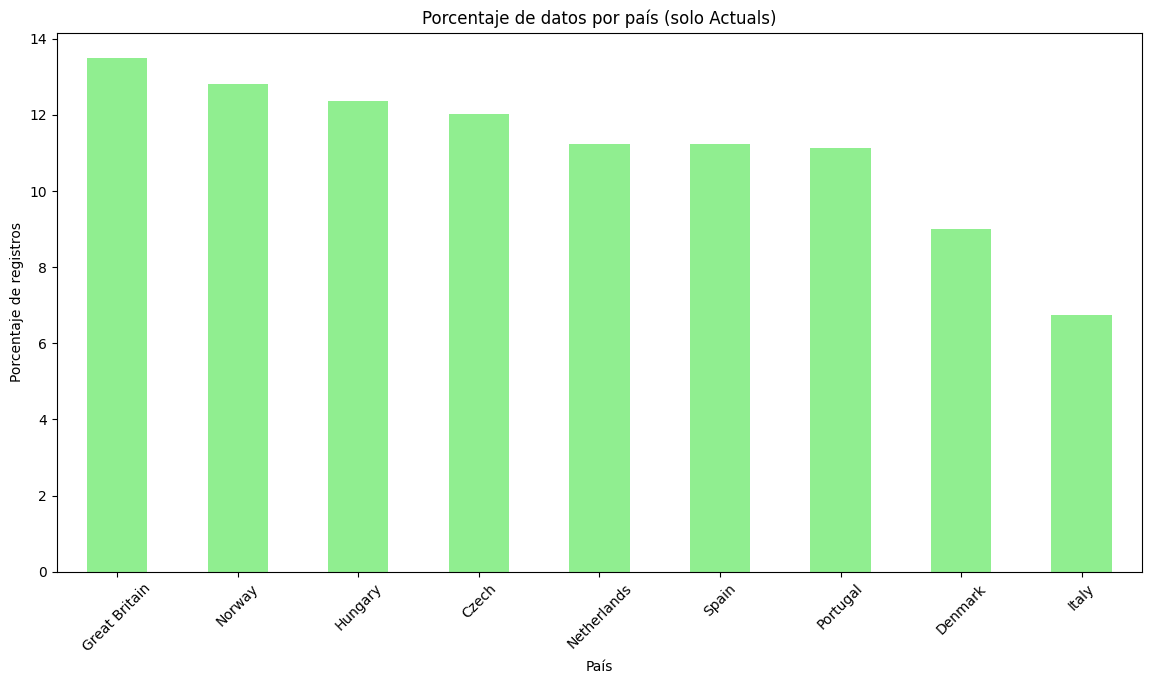

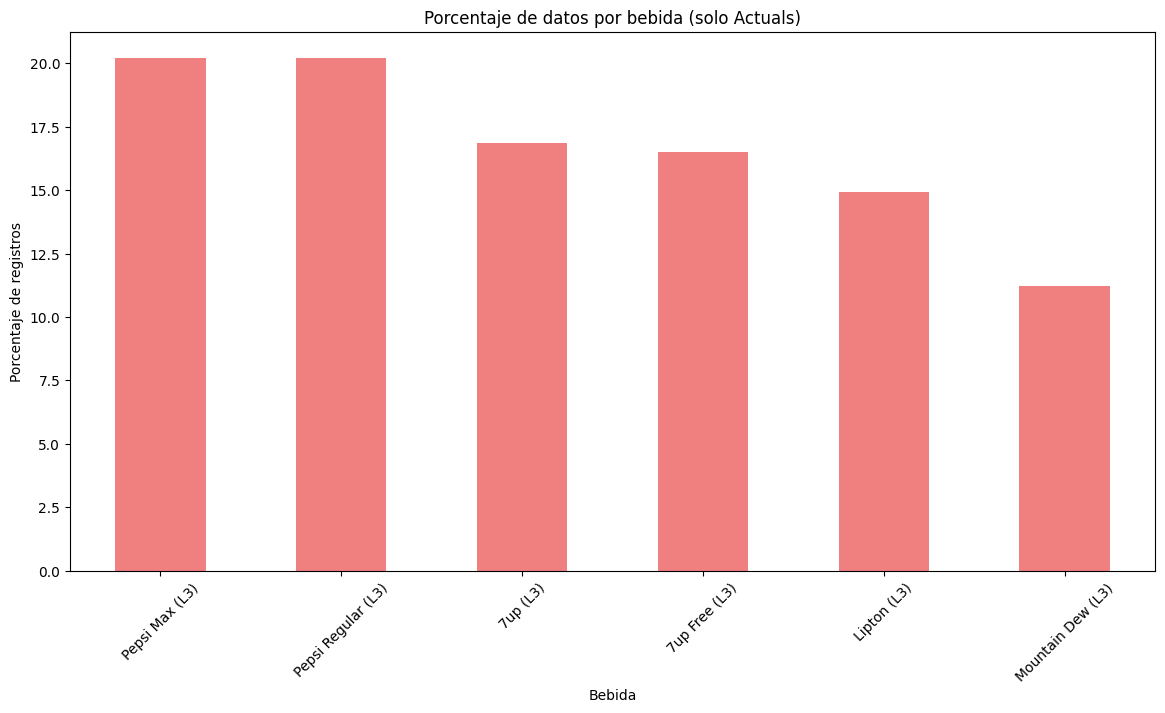

In [106]:
# Ahora filtramos solo los datos de 'Actual'
df_actuals = df[df['SCENARIO'].str.strip().str.lower() == 'actual']

# Gráfico de barras para el porcentaje de datos por país (solo Actuals)
conteo_paises_actuals = df_actuals['COUNTRY'].value_counts(normalize=True) * 100

plt.figure(figsize=(14, 7))
conteo_paises_actuals.plot(kind='bar', color='lightgreen')

plt.title("Porcentaje de datos por país (solo Actuals)")
plt.xlabel("País")
plt.ylabel("Porcentaje de registros")
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para el porcentaje de datos por bebida (solo Actuals)
conteo_bebidas_actuals = df_actuals['SUBBRAND'].value_counts(normalize=True) * 100  # Asegurarse de que 'SUBBRAND' esté bien escrito

plt.figure(figsize=(14, 7))
conteo_bebidas_actuals.plot(kind='bar', color='lightcoral')  # Cambiar a 'conteo_bebidas_actuals' para el gráfico correcto

plt.title("Porcentaje de datos por bebida (solo Actuals)")
plt.xlabel("Bebida")
plt.ylabel("Porcentaje de registros")
plt.xticks(rotation=45)
plt.show()

Ahora, calcularemos el horizonte de previsión.

El número de meses que he predicho para Spain y 7up (L3) es: 18


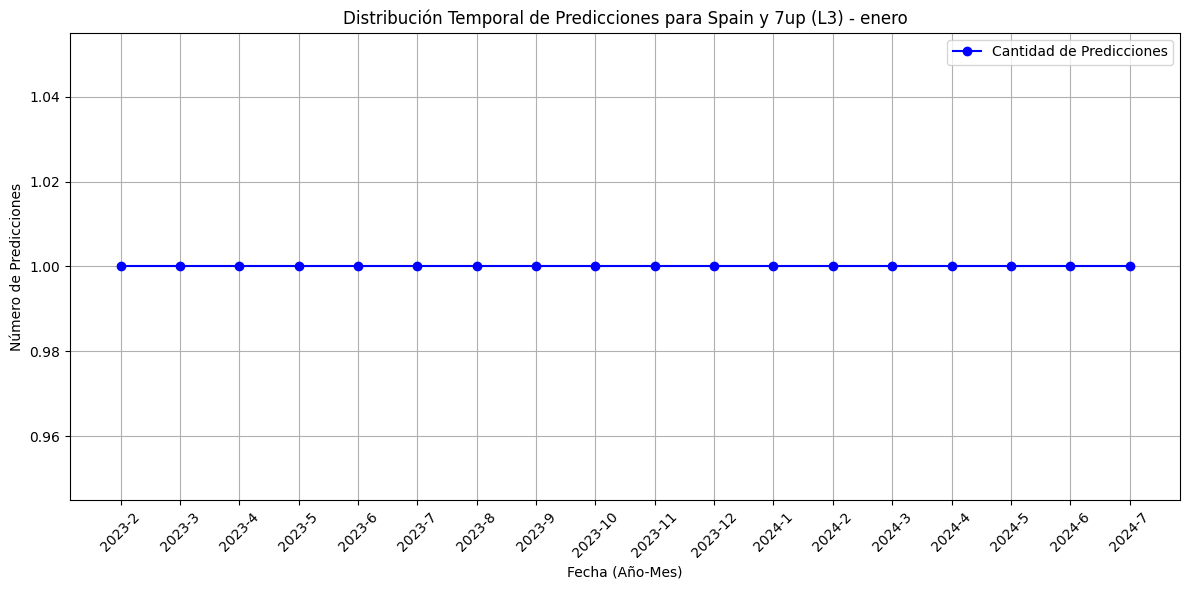

In [107]:
# Definimos el país y bebida específicos para el análisis
pais_especifico = "Spain"
bebida_especifica = "7up (L3)"
forecast_tipo = "enero"

# Filtramos las predicciones específicas para España y 7up
conteo_forecast = df[(df['COUNTRY'] == pais_especifico) &
                     (df['SUBBRAND'] == bebida_especifica) &
                     (df['FORECAST'] == forecast_tipo)].shape[0]

print(f"El número de meses que he predicho para {pais_especifico} y {bebida_especifica} es: {conteo_forecast}")

# Filtramos las predicciones para España, 7up y el tipo de forecast específico
predicciones_filtradas = df[(df['COUNTRY'] == pais_especifico) &
                            (df['SUBBRAND'] == bebida_especifica) &
                            (df['FORECAST'] == forecast_tipo)]

# Agrupamos por año y mes para contar la cantidad de predicciones realizadas en cada mes
predicciones_por_mes = predicciones_filtradas.groupby(['YEAR', 'MONTH']).size().reset_index(name='COUNT')

# Creamos una columna de Fecha en formato Año-Mes para usar en el gráfico
predicciones_por_mes['Fecha'] = predicciones_por_mes['YEAR'].astype(str) + '-' + predicciones_por_mes['MONTH'].astype(str)

# Graficamos la distribución temporal de las predicciones
plt.figure(figsize=(12, 6))
plt.plot(predicciones_por_mes['Fecha'], predicciones_por_mes['COUNT'], marker='o', color='b', label='Cantidad de Predicciones')
plt.xlabel("Fecha (Año-Mes)")
plt.ylabel("Número de Predicciones")
plt.title(f"Distribución Temporal de Predicciones para {pais_especifico} y {bebida_especifica} - {forecast_tipo}")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Observamos que el horizonte de previsión es 18 y que se realiza una predicción cada mes durantes todos los meses que tiene la base de datos. Para comprobarlo:

In [108]:
# Verificamos los datos agrupados por mes
print("Datos agrupados por mes y año:")
print(predicciones_por_mes)

# Mostramos las predicciones filtradas por año, mes y tipo de forecast
print(f"\nDatos filtrados para {pais_especifico}, {bebida_especifica}, y {forecast_tipo}:")
print(predicciones_filtradas[['YEAR', 'MONTH', 'FORECAST']])

Datos agrupados por mes y año:
    YEAR  MONTH  COUNT    Fecha
0   2023      2      1   2023-2
1   2023      3      1   2023-3
2   2023      4      1   2023-4
3   2023      5      1   2023-5
4   2023      6      1   2023-6
5   2023      7      1   2023-7
6   2023      8      1   2023-8
7   2023      9      1   2023-9
8   2023     10      1  2023-10
9   2023     11      1  2023-11
10  2023     12      1  2023-12
11  2024      1      1   2024-1
12  2024      2      1   2024-2
13  2024      3      1   2024-3
14  2024      4      1   2024-4
15  2024      5      1   2024-5
16  2024      6      1   2024-6
17  2024      7      1   2024-7

Datos filtrados para Spain, 7up (L3), y enero:
       YEAR  MONTH FORECAST
68     2024      4    enero
5333   2024      3    enero
5637   2024      6    enero
6240   2023      5    enero
8869   2023      6    enero
9466   2024      5    enero
10903  2023      4    enero
12389  2023      7    enero
12614  2024      7    enero
13296  2023      8    enero
13767

Por último, en la sección de limpieza y entendimiento de la base de datos, vamos a ver cuantos tipos de forecast tenemos.

Número de tipos distintos de forecast: 12
Volumen de cada tipo de forecast:
 FORECAST
noviembre     1614
septiembre    1560
julio         1554
octubre       1551
agosto        1536
junio         1451
abril         1420
marzo         1403
mayo          1396
enero         1206
febrero       1206
diciembre     1206
Name: count, dtype: int64


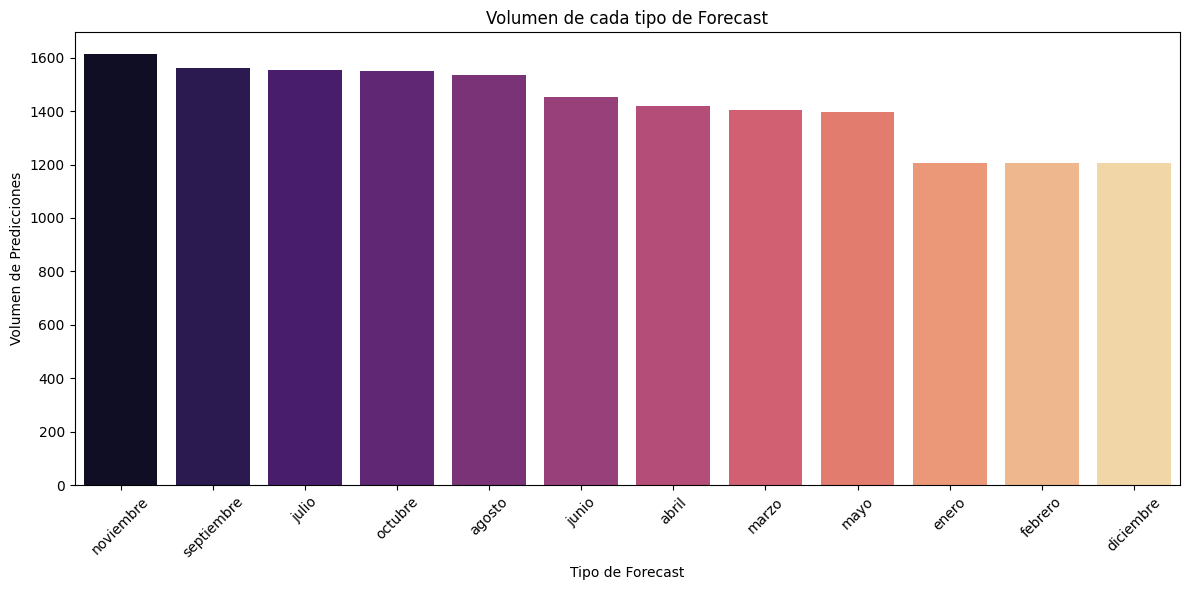

In [109]:
# Contamos el número de tipos distintos de forecast y el volumen de cada uno
forecast_counts = df['FORECAST'].value_counts()
num_forecast_types = forecast_counts.shape[0]

print(f"Número de tipos distintos de forecast: {num_forecast_types}")
print("Volumen de cada tipo de forecast:\n", forecast_counts)

# Creamos el gráfico de barras con la paleta de color 'magma' en minúsculas
plt.figure(figsize=(12, 6))
sns.barplot(x=forecast_counts.index, y=forecast_counts.values, palette="magma")

plt.title("Volumen de cada tipo de Forecast")
plt.xlabel("Tipo de Forecast")
plt.ylabel("Volumen de Predicciones")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Una vez analizada la base de datos, estamos preparados para poder trabajar con ella.

## **PREGUNTAS QUE RESPONDER.**

1. Como se distribuyen las ventas realizadas en:
    - Cada país.
    - Cada mes y año.
    - Cada marca.

2. Cual es la tendencia y estacionalidad de:
    - Todas las ventas del país con menos ventas.
    - La marca con más ventas.

3. Cuales son las predicciones hechas en España y como de
buenas son.

-------

En esta primera parte del análisis, vamos a explorar cómo se distribuyen las ventas realizadas en cada país. Este análisis nos ayudará a identificar los mercados con mayor volumen de ventas y a visualizar las diferencias entre los distintos países.

In [110]:
# Filtramos las ventas reales (Actual) y prepararamos columnas
ventas_actual = df[df['SCENARIO'].str.strip().str.lower() == 'actual']
ventas_actual = ventas_actual.sort_values(by=['YEAR', 'MONTH'])
ventas_actual['Fecha'] = pd.to_datetime(ventas_actual[['YEAR', 'MONTH']].assign(DAY=1))

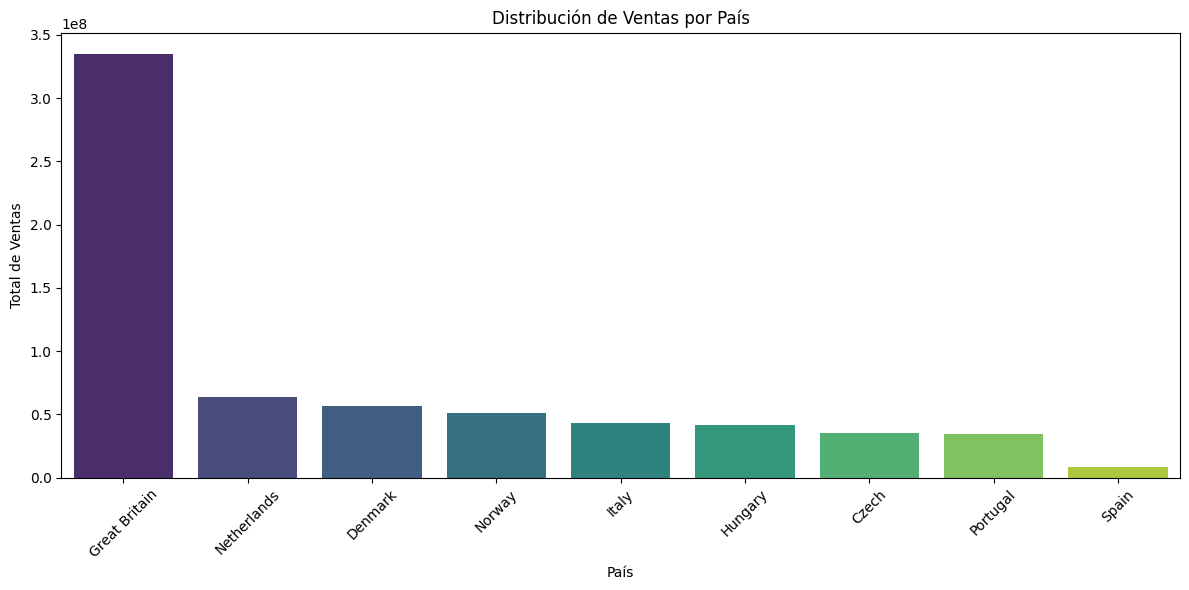

In [111]:
# 1. Distribución de Ventas por País
ventas_por_pais = ventas_actual.groupby('COUNTRY')['AMOUNT'].sum().reset_index()
ventas_por_pais = ventas_por_pais.sort_values(by='AMOUNT', ascending=False)

# Gráfico de barras de ventas por país
plt.figure(figsize=(12, 6))
sns.barplot(x=ventas_por_pais['COUNTRY'], y=ventas_por_pais['AMOUNT'], palette="viridis")
plt.title("Distribución de Ventas por País")
plt.xlabel("País")
plt.ylabel("Total de Ventas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Este gráfico nos muestra claramente cómo se distribuyen las ventas por país. Podemos observar cuáles son los países con mayor y menor volumen de ventas, lo que proporciona una visión inicial de los mercados más importantes para la empresa.

También, usamos un mapa de calor del cual sacamos la misma información que en el de arriba pero de una manera más agradable.

In [112]:
iso_codes = {
    "Great Britain": "GBR", "Denmark": "DNK", "Norway": "NOR", "Netherlands": "NLD",
    "Hungary": "HUN", "Czech": "CZE", "Italy": "ITA", "Portugal": "PRT", "Spain": "ESP"
}
ventas_por_pais['ISO3'] = ventas_por_pais['COUNTRY'].map(iso_codes)

fig = px.choropleth(
    ventas_por_pais,
    locations='ISO3',
    color='AMOUNT',
    hover_name='COUNTRY',
    color_continuous_scale=px.colors.sequential.Plasma,
    scope='europe'
)
fig.update_layout(title_text="Distribución de Ventas por País (Europa)")
fig.show()

Ya sabemos como se distribuyen todas las ventas en cada pais, pero también nos interesa ver que se vende más en cada paises. Para ello creamos este gráfico que nos da toda la información ordenada por paises.

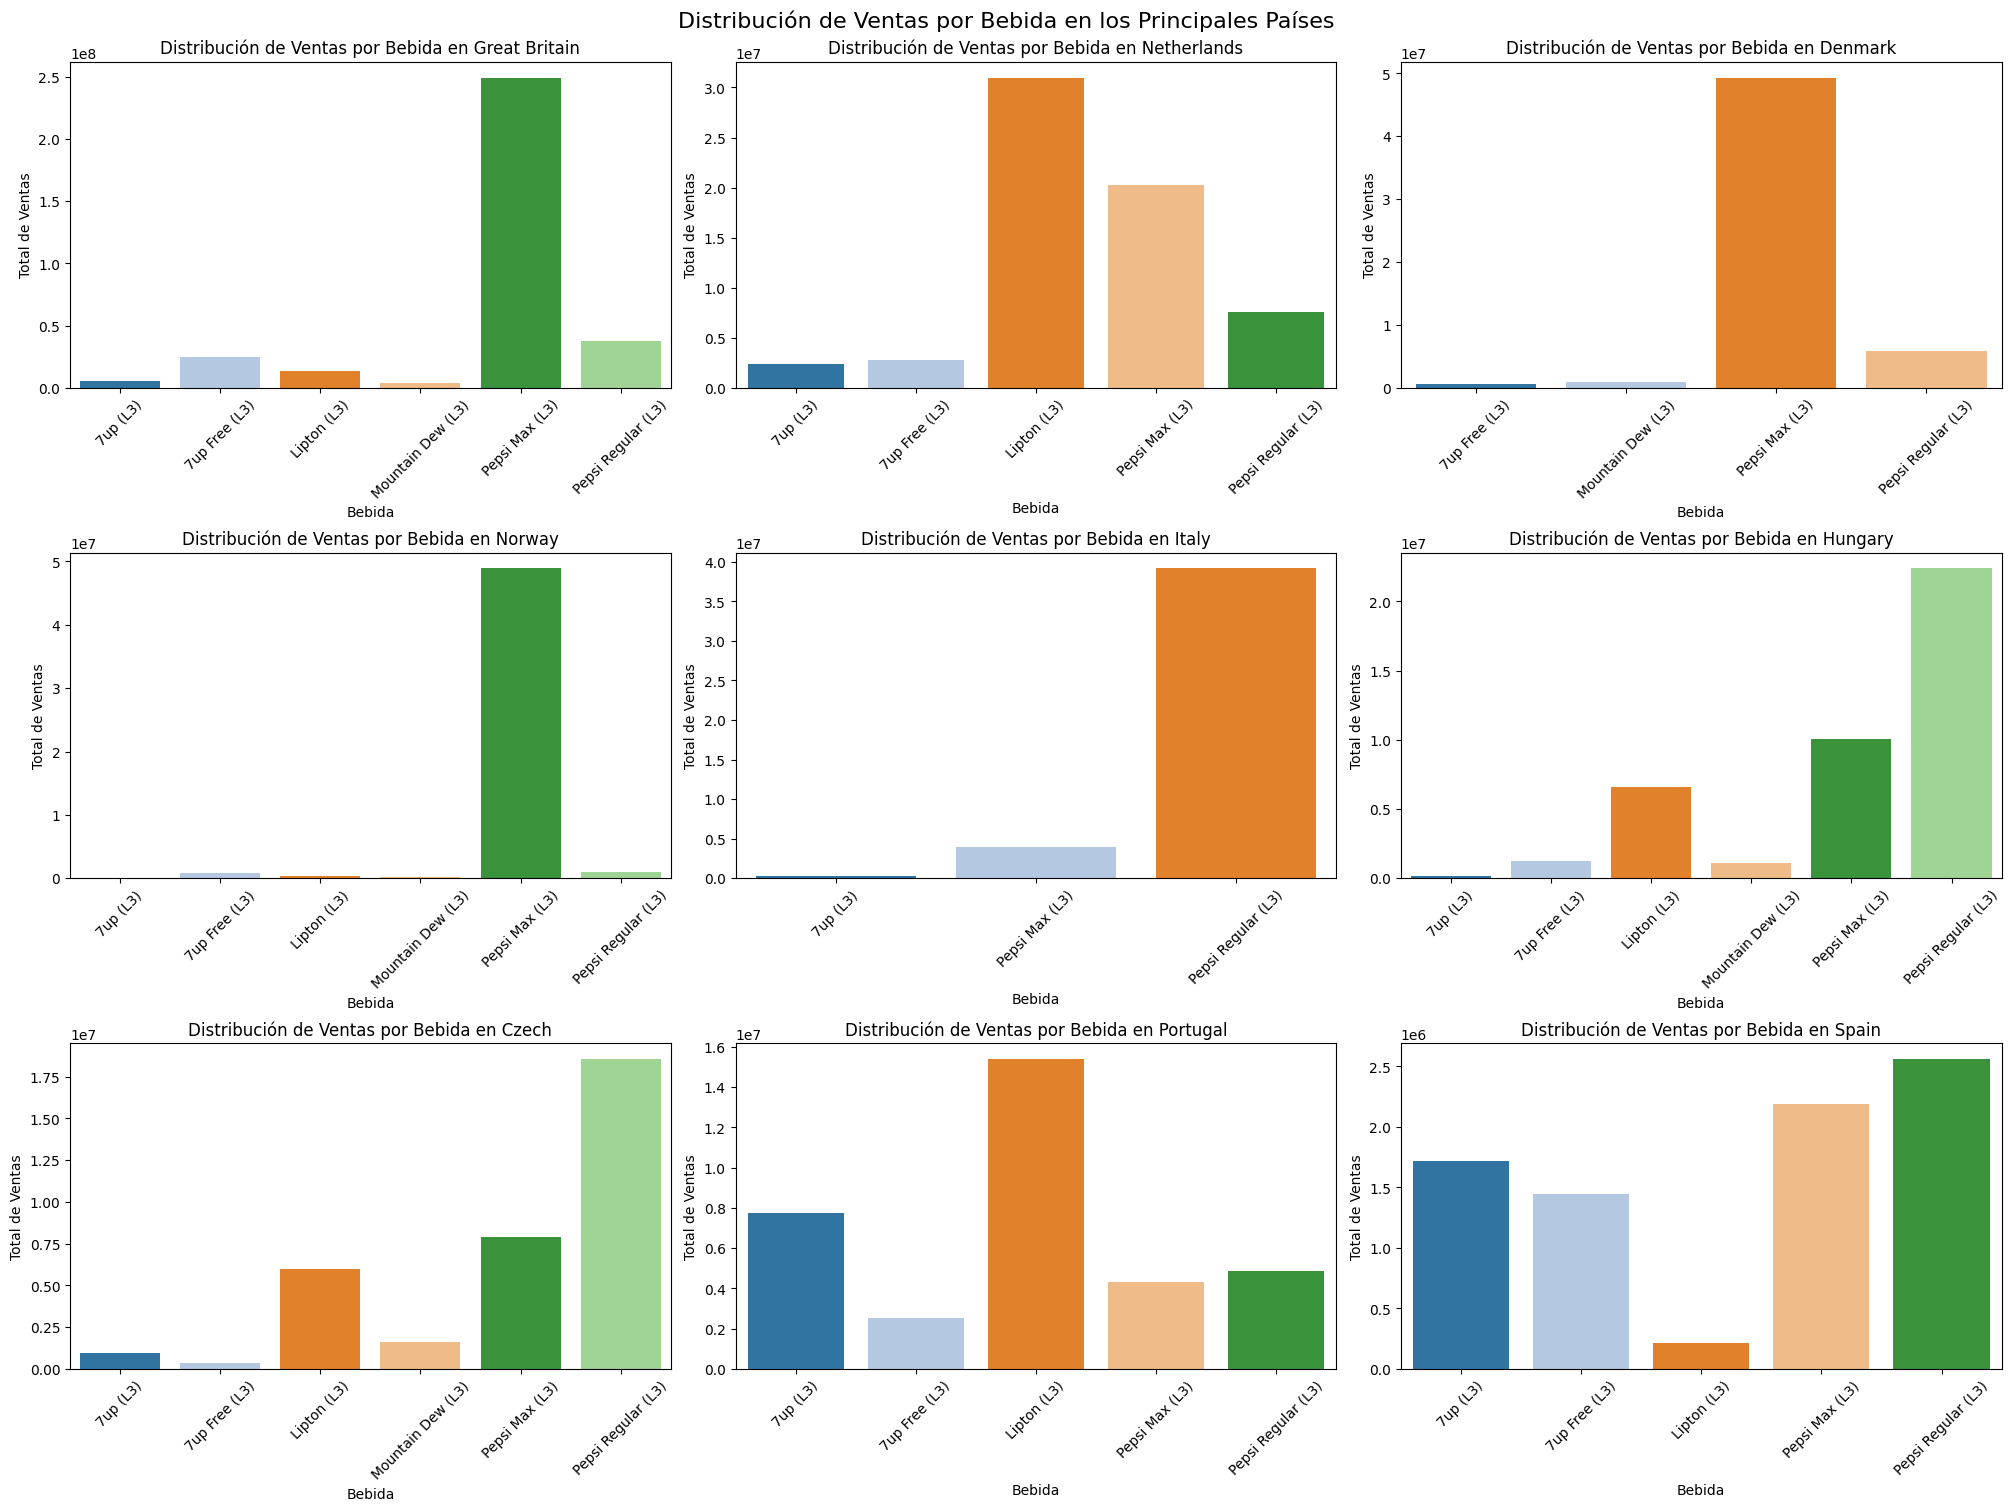

In [113]:
# Distribución de Ventas por Bebida en Países
top_paises = ventas_por_pais['COUNTRY'].head(9)
ventas_top_paises = ventas_actual[ventas_actual['COUNTRY'].isin(top_paises)]

fig, axes = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)
for i, pais in enumerate(top_paises):
    ax = axes[i // 3, i % 3]
    ventas_por_bebida = ventas_top_paises[ventas_top_paises['COUNTRY'] == pais].groupby('SUBBRAND')['AMOUNT'].sum().reset_index()
    sns.barplot(data=ventas_por_bebida, x='SUBBRAND', y='AMOUNT', ax=ax, palette='tab20')
    ax.set_title(f"Distribución de Ventas por Bebida en {pais}")
    ax.set_xlabel("Bebida")
    ax.set_ylabel("Total de Ventas")
    ax.tick_params(axis='x', rotation=45)
fig.suptitle("Distribución de Ventas por Bebida en los Principales Países", fontsize=16)
plt.show()

Ahora, analizaremos cómo se distribuyen las ventas por mes y año. Esto nos permitirá identificar patrones temporales, como tendencias crecientes o decrecientes, y posibles efectos estacionales en los datos de ventas.

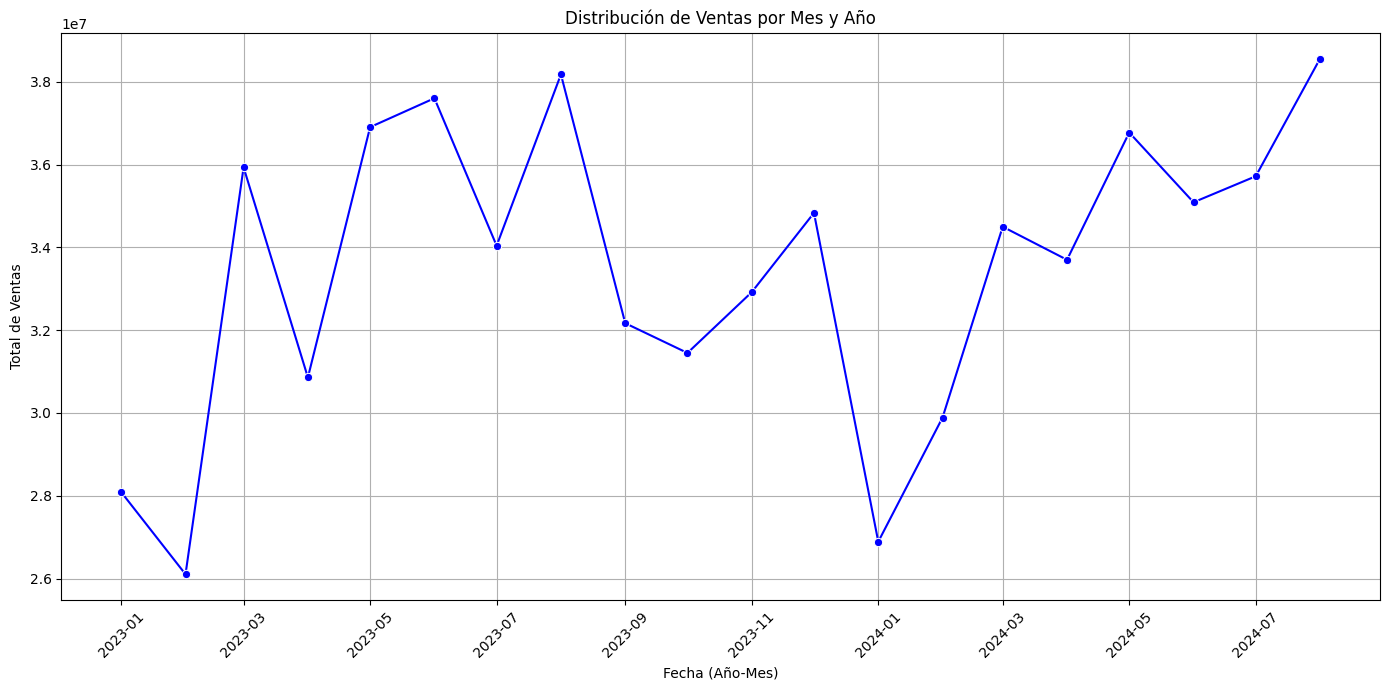

In [114]:
# 2. Distribución de Ventas por Mes y Año
ventas_por_mes_anio = ventas_actual.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()
ventas_por_mes_anio['Fecha'] = pd.to_datetime(ventas_por_mes_anio[['YEAR', 'MONTH']].assign(DAY=1))

plt.figure(figsize=(14, 7))
sns.lineplot(data=ventas_por_mes_anio, x='Fecha', y='AMOUNT', marker='o', color="b")
plt.title("Distribución de Ventas por Mes y Año")
plt.xlabel("Fecha (Año-Mes)")
plt.ylabel("Total de Ventas")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Este gráfico muestra la evolución de las ventas por mes y año, revelando fluctuaciones claras en la demanda. Observamos picos en ciertos meses y caídas en otros, lo que sugiere posibles patrones estacionales. La comparación entre 2023 y 2024 ayuda a identificar cambios en la tendencia anual.

Al igual que hemos hecho antes, representamos la cantidad de ventas de cada bebida en grupos de 5 meses.

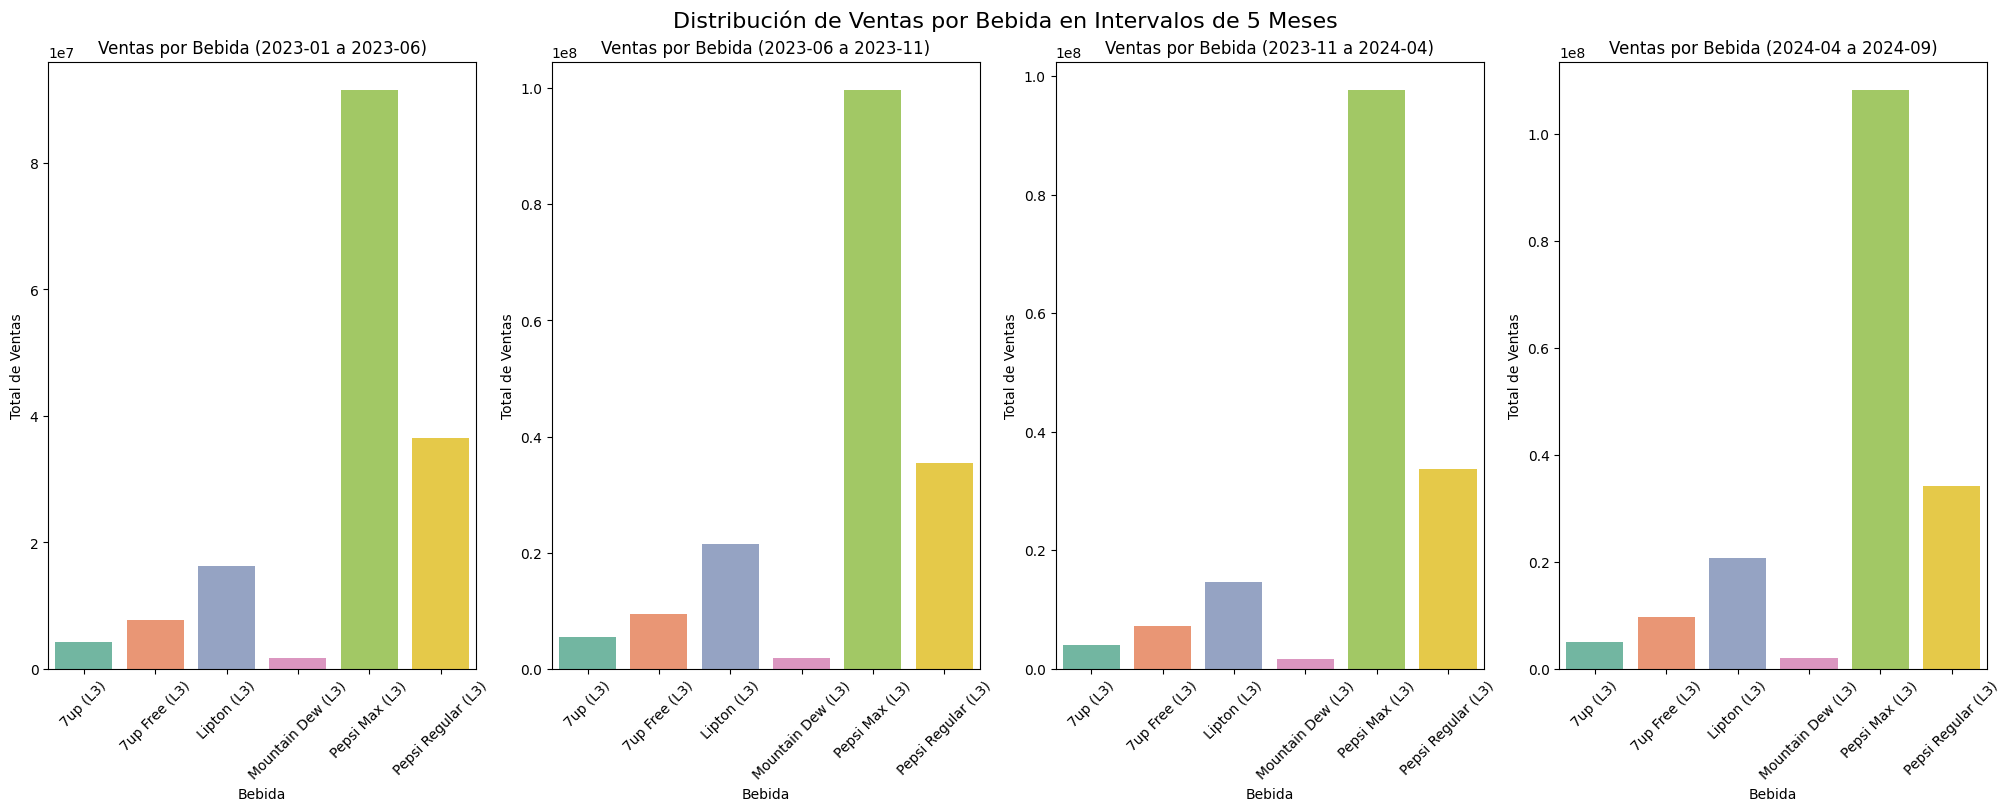

In [115]:
# Distribución de Ventas por Bebida en Intervalos de 5 Meses
intervalos = [ventas_actual['Fecha'].min() + pd.DateOffset(months=5 * i) for i in range(4)]
fig, axes = plt.subplots(1, 4, figsize=(20, 8), constrained_layout=True)

for i, inicio in enumerate(intervalos):
    fin = inicio + pd.DateOffset(months=5)
    ventas_intervalo = ventas_actual[(ventas_actual['Fecha'] >= inicio) & (ventas_actual['Fecha'] < fin)]
    ventas_por_bebida = ventas_intervalo.groupby('SUBBRAND')['AMOUNT'].sum().reset_index()
    sns.barplot(data=ventas_por_bebida, x='SUBBRAND', y='AMOUNT', ax=axes[i], palette='Set2')
    axes[i].set_title(f"Ventas por Bebida ({inicio.strftime('%Y-%m')} a {fin.strftime('%Y-%m')})")
    axes[i].set_xlabel("Bebida")
    axes[i].set_ylabel("Total de Ventas")
    axes[i].tick_params(axis='x', rotation=45)
fig.suptitle("Distribución de Ventas por Bebida en Intervalos de 5 Meses", fontsize=16)
plt.show()

Por último, aunque ya sepamos la distribución de la cantidad total de ventas separadas en bebidas, vamos a representarlas solas ya que antes estaba en función de los paises o las fechas.

In [116]:
# 3. Distribución Total de Ventas por Bebida (Treemap)
ventas_por_bebida_total = ventas_actual.groupby('SUBBRAND')['AMOUNT'].sum().reset_index()
fig = px.treemap(
    ventas_por_bebida_total,
    path=['SUBBRAND'],
    values='AMOUNT',
    color='AMOUNT',
    color_continuous_scale='Blues'
)
fig.update_layout(title="Distribución de Ventas por Bebida.")
fig.show()

Este treemap nos da una visión muy clara de cuales son las bebidas que mas se venden.

---

En este paso, vamos a analizar la tendencia y estacionalidad de las ventas en dos países con características contrastantes: España, que presenta el menor volumen de ventas, y Gran Bretaña, el país con el mayor volumen de ventas. Este análisis nos ayudará a identificar patrones de comportamiento en las ventas a lo largo del tiempo en ambos países y a detectar posibles estacionalidades que puedan influir en la demanda.

In [117]:
# Filtramos los datos de ventas reales (Actual) para España y Gran Bretaña
ventas_espana = ventas_actual[ventas_actual['COUNTRY'] == 'Spain']
ventas_gran_bretana = ventas_actual[ventas_actual['COUNTRY'] == 'Great Britain']

# Agrupamos las ventas por mes y año para cada país
ventas_espana_mensual = ventas_espana.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()
ventas_gran_bretana_mensual = ventas_gran_bretana.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()

# Creamos la columna de fecha para facilitar el análisis temporal
ventas_espana_mensual['Fecha'] = pd.to_datetime(ventas_espana_mensual[['YEAR', 'MONTH']].assign(DAY=1))
ventas_gran_bretana_mensual['Fecha'] = pd.to_datetime(ventas_gran_bretana_mensual[['YEAR', 'MONTH']].assign(DAY=1))


Para visualizar la evolución de las ventas mensuales en cada país, crearemos un gráfico de líneas que muestre la tendencia a lo largo del tiempo.

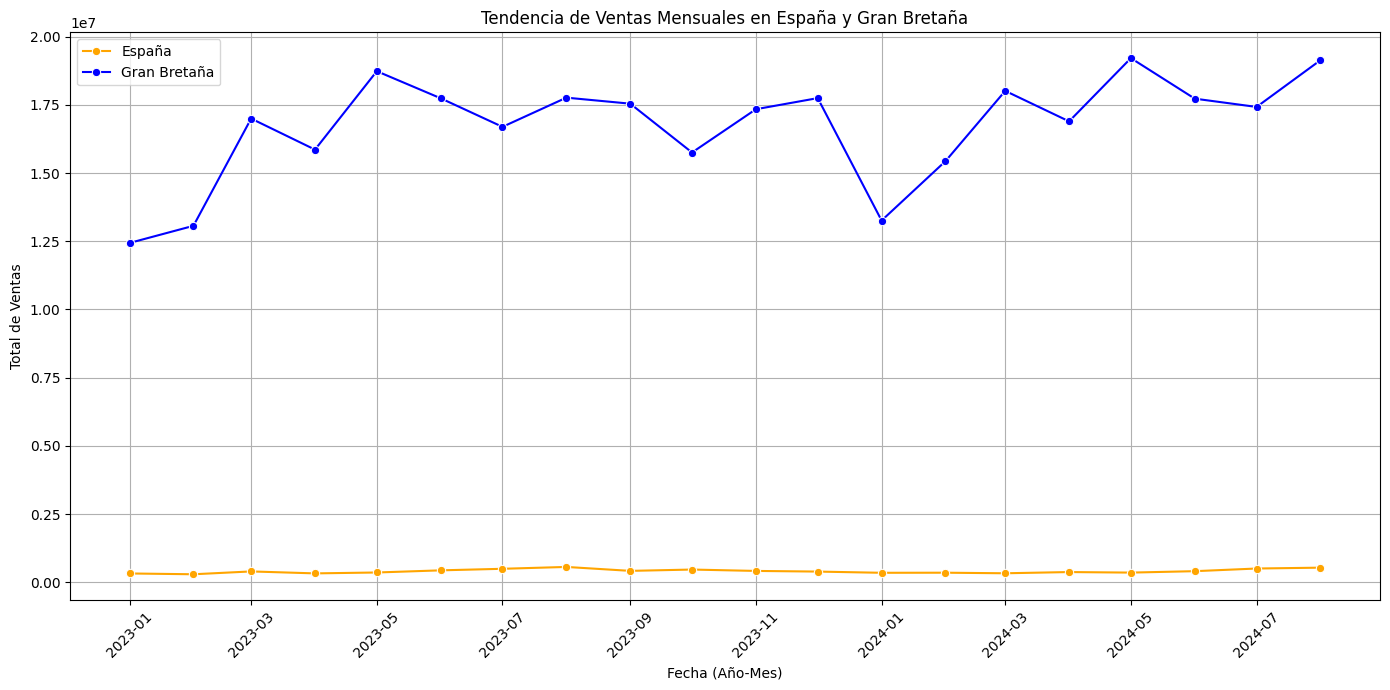

In [118]:
plt.figure(figsize=(14, 7))

# Gráfico de líneas para España
sns.lineplot(data=ventas_espana_mensual, x='Fecha', y='AMOUNT', label='España', color='orange', marker='o')

# Gráfico de líneas para Gran Bretaña
sns.lineplot(data=ventas_gran_bretana_mensual, x='Fecha', y='AMOUNT', label='Gran Bretaña', color='blue', marker='o')

plt.title("Tendencia de Ventas Mensuales en España y Gran Bretaña")
plt.xlabel("Fecha (Año-Mes)")
plt.ylabel("Total de Ventas")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Vemos que hay grandes diferencias entre ambos por lo que vamos a realizar el estudio por separado.

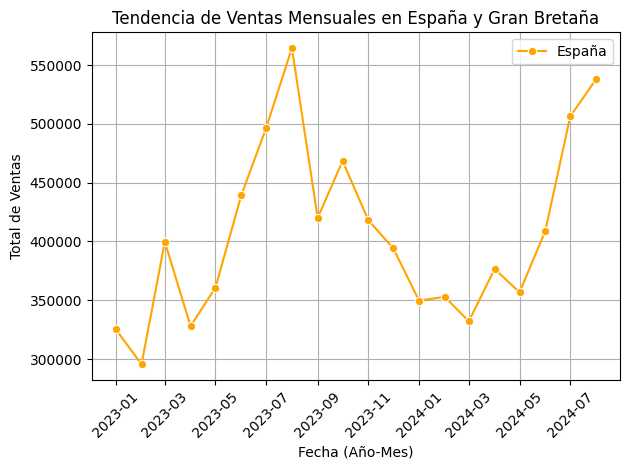

In [119]:
# Gráfico de líneas para España
sns.lineplot(data=ventas_espana_mensual, x='Fecha', y='AMOUNT', label='España', color='orange', marker='o')

plt.title("Tendencia de Ventas Mensuales en España y Gran Bretaña")
plt.xlabel("Fecha (Año-Mes)")
plt.ylabel("Total de Ventas")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

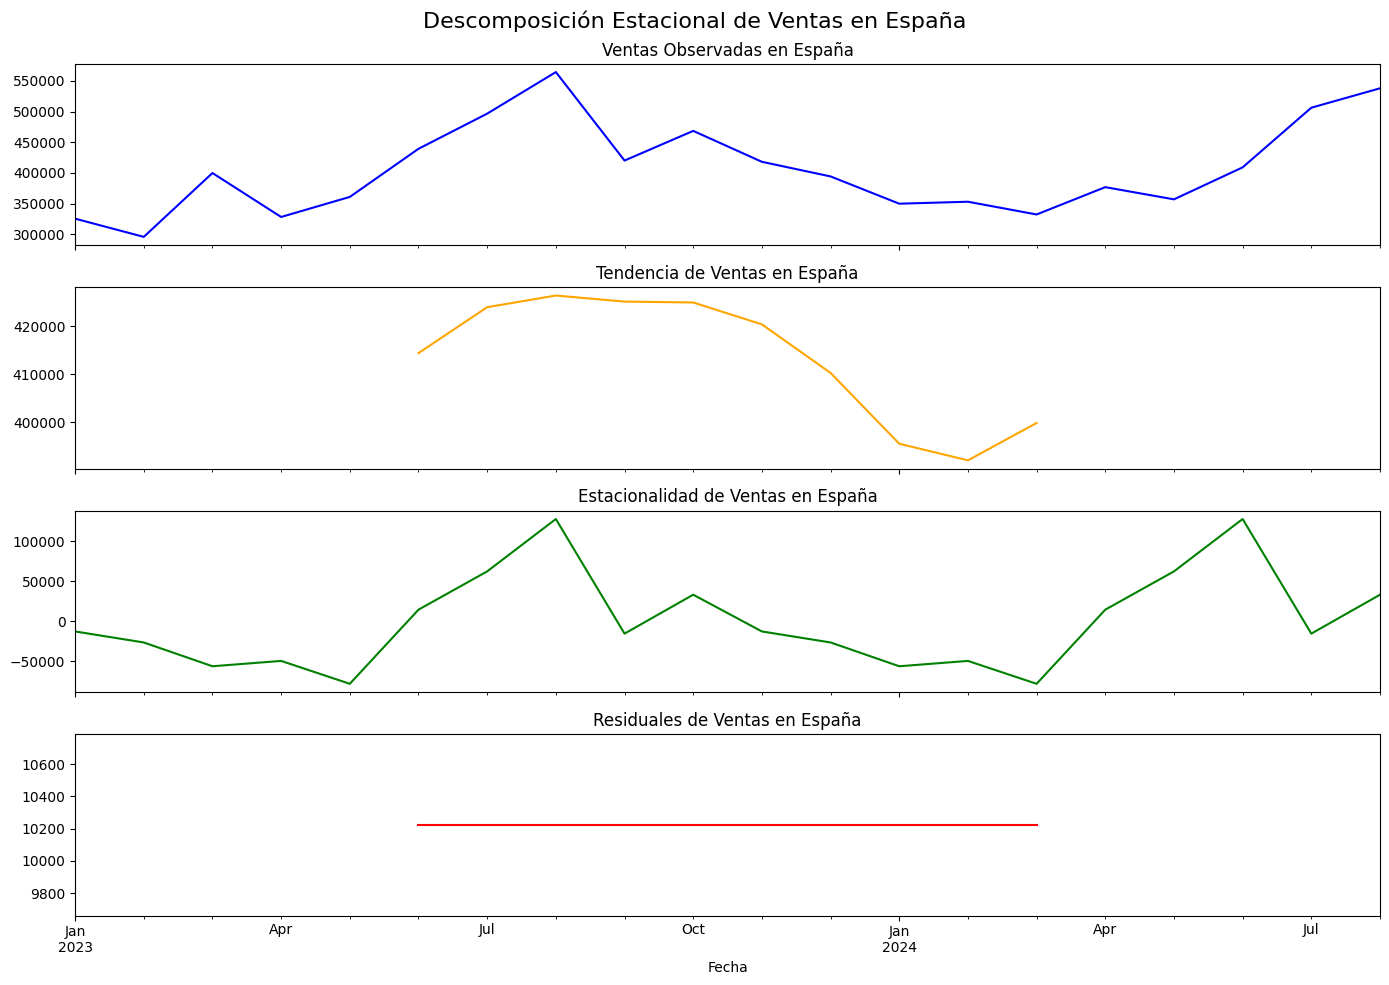

In [120]:
# Descomposición estacional para España con periodo de 6 meses
decompose_espana = seasonal_decompose(ventas_espana_mensual.set_index('Fecha')['AMOUNT'], model='additive', period=10)

# Configuración del tamaño de la figura y separación de los subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
decompose_espana.observed.plot(ax=axes[0], color='blue', title='Ventas Observadas en España')
decompose_espana.trend.plot(ax=axes[1], color='orange', title='Tendencia de Ventas en España')
decompose_espana.seasonal.plot(ax=axes[2], color='green', title='Estacionalidad de Ventas en España')
decompose_espana.resid.plot(ax=axes[3], color='red', title='Residuales de Ventas en España')
fig.suptitle("Descomposición Estacional de Ventas en España", fontsize=16)
plt.tight_layout()
plt.show()

En España, la tendencia general de ventas muestra un crecimiento moderado al principio del periodo (10 meses empezando en enero), seguido por una fase de estabilización y una leve disminución en la segunda mitad, aunque finalmete tiene una recuperación. Tiene una demanda variada con una tendencia al alza en ciertos momentos del año.

La estacionalidad revela picos claros en el meses de julio, indicando periodos de alta demanda, posiblemente por el verano. Por otro lado, los valles de aparecen en marzo donde la demanda tiende a reducirse.

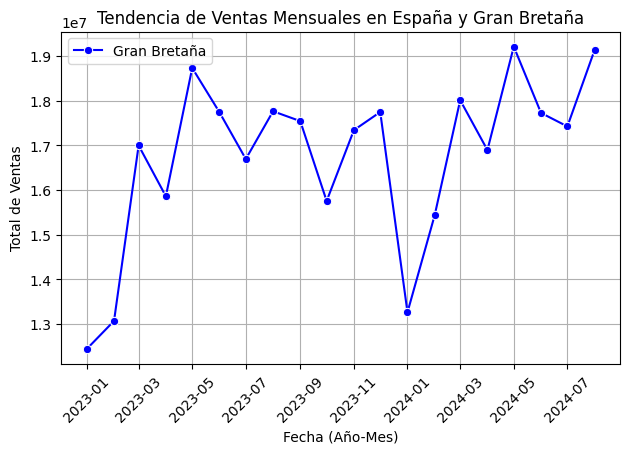

In [121]:
# Gráfico de líneas para Gran Bretaña
sns.lineplot(data=ventas_gran_bretana_mensual, x='Fecha', y='AMOUNT', label='Gran Bretaña', color='blue', marker='o')

plt.title("Tendencia de Ventas Mensuales en España y Gran Bretaña")
plt.xlabel("Fecha (Año-Mes)")
plt.ylabel("Total de Ventas")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

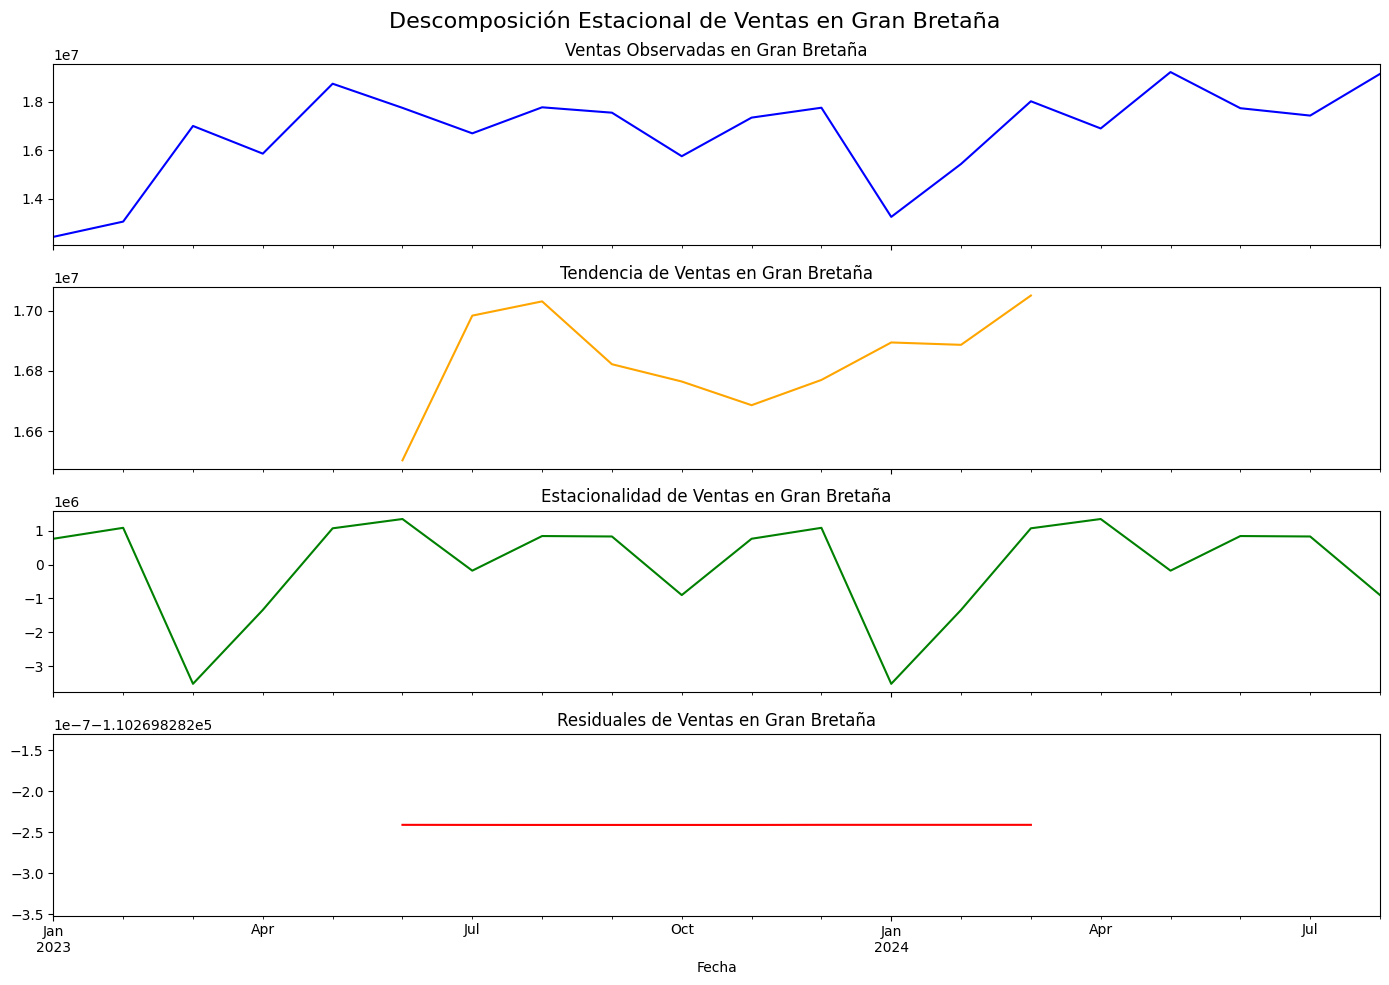

In [122]:
# Descomposición estacional para Gran Bretaña con periodo de 6 meses
decompose_gran_bretana = seasonal_decompose(ventas_gran_bretana_mensual.set_index('Fecha')['AMOUNT'], model='additive', period=10)

# Configuración del tamaño de la figura y separación de los subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
decompose_gran_bretana.observed.plot(ax=axes[0], color='blue', title='Ventas Observadas en Gran Bretaña')
decompose_gran_bretana.trend.plot(ax=axes[1], color='orange', title='Tendencia de Ventas en Gran Bretaña')
decompose_gran_bretana.seasonal.plot(ax=axes[2], color='green', title='Estacionalidad de Ventas en Gran Bretaña')
decompose_gran_bretana.resid.plot(ax=axes[3], color='red', title='Residuales de Ventas en Gran Bretaña')
fig.suptitle("Descomposición Estacional de Ventas en Gran Bretaña", fontsize=16)
plt.tight_layout()
plt.show()


En Gran Bretaña, la tendencia de ventas muestra un aumento al inicio del periodo de 10 meses, alcanzando su punto más alto hacia la mitad (mayo), seguido de una ligera disminución y más tarde se estabiliza. Esto indica una demanda que comienza fuerte y se modera conforme avanza el año.

En cuanto a la estacionalidad, se observan picos en el meses de mayo. Los niveles de demanda más bajos se dan en enero al igual que en España.


Comparando ambos países, podemos ver como ya sabiamos una gran diferencia en la cantidad total de ventas.

 En ambos casos, la estacionalidad es anual, ya que los picos de demanda se repiten de manera similar cada año, coincidiendo además en los meses de mayo y julio (primavera y verano), mientras que la demanda disminuye progresivamente hacia los meses de diciembre y enero (invierno).

Este análisis permite a las empresas ajustar sus estrategias de ventas según los patrones estacionales de cada mercado, maximizando los recursos y campañas en los periodos de alta demanda y optimizando inventarios en los meses de menor actividad.

Además, solo por obtener mas información de estos dos paises que estamos estudiando, vamos a volver a ver de forma individual como se distribuyen las ventas.

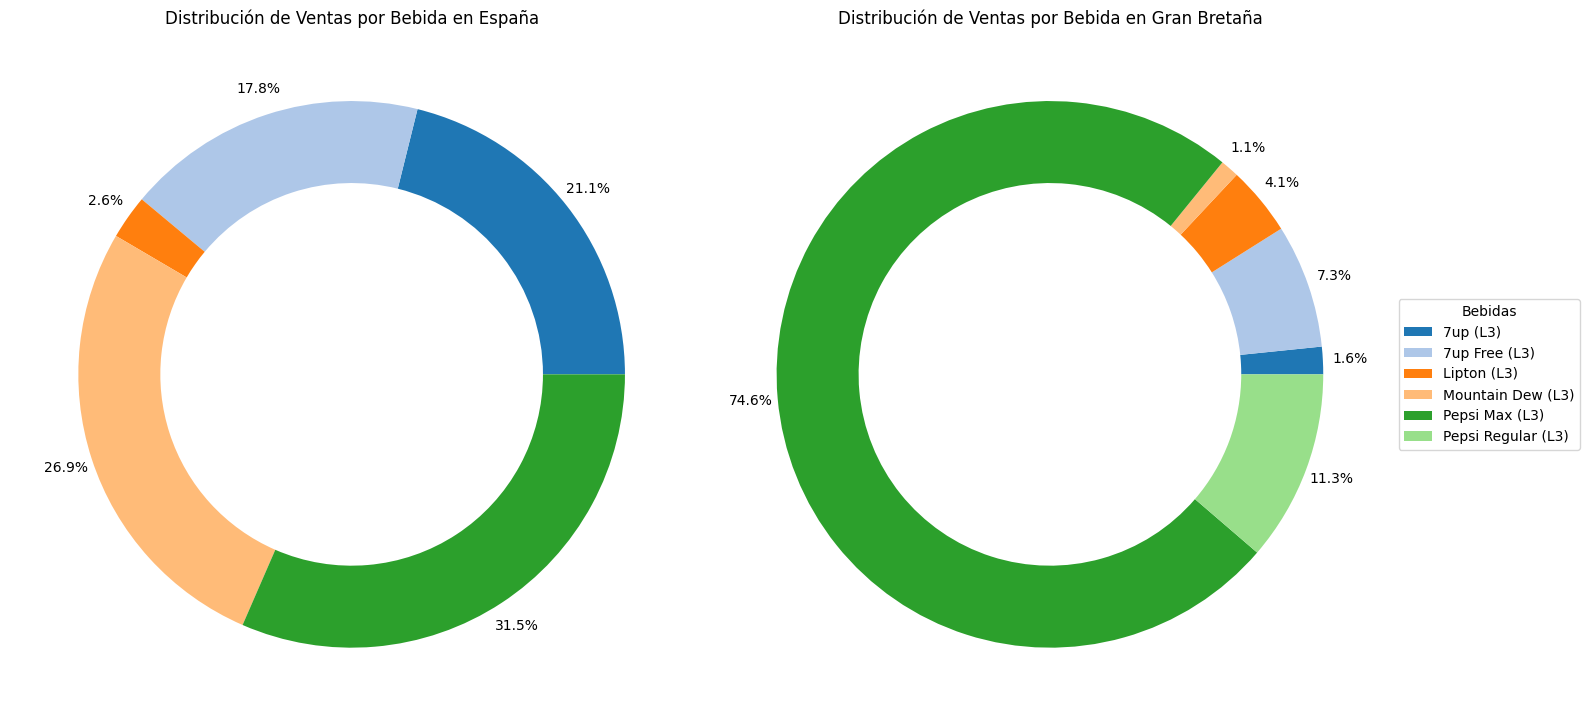

In [123]:
# Configuración del gráfico
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
colors = plt.cm.tab20.colors

# Gráfico de tarta para España
axes[0].pie(
    ventas_espana_bebida,
    labels=None,
    autopct='%1.1f%%',
    pctdistance=1.1,
    colors=colors,
    wedgeprops={'width': 0.3}
)
axes[0].set_title('Distribución de Ventas por Bebida en España')

# Gráfico de tarta para Gran Bretaña
axes[1].pie(
    ventas_gran_bretana_bebida,
    labels=None,
    autopct='%1.1f%%',
    pctdistance=1.1,
    colors=colors,
    wedgeprops={'width': 0.3}
)
axes[1].set_title('Distribución de Ventas por Bebida en Gran Bretaña')

# Agregamos una leyenda compartida fuera de los gráficos
plt.legend(
    ventas_gran_bretana_bebida.index,
    title="Bebidas",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

# Mostramos los gráficos
plt.tight_layout()
plt.show()

Además de tener volumenes de ventas muy diferentes, pode mos apreciar como dependiendo el pais, las ventas de diferentes bebidas son mjuy diferentes.

----

Por último, vamos a analizar las predicciones de ventas en España y evaluar su precisión. Tenemos que comparar los valores pronosticados con los valores reales, lo cual es imuy importante para entender cómo de exactas son las previsiones y en qué medida las predicciones pueden ser útiles para la empresa.

 En primer lugar, filtramos los datos de España y creamos una columna que convierte el valor FORECAST en el mes correspondiente.

In [128]:
df = df[df['COUNTRY'] == 'Spain'].copy()

forecast_a_mes = {
    'AI_P02F': 2, 'AI_P03F': 3, 'AI_P04F': 4,
    'AI_P05F': 5, 'AI_P06F': 6, 'AI_P07F': 7,
    'AI_P08F': 8, 'AI_P09F': 9, 'AI_P10F': 10,
    'AI_P11F': 11, 'AI_P12F': 12, 'AI_PF': 1
}

df.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,agosto,2023.0,88501.980847
20,Spain,Pepsi Regular (L3),2023,12,AI_forecast,abril,2023.0,134268.151080
25,Spain,Lipton (L3),2025,3,AI_forecast,octubre,2023.0,9702.217953
62,Spain,7up Free (L3),2024,1,AI_forecast,marzo,2023.0,70144.329753
68,Spain,7up (L3),2024,4,AI_forecast,enero,2023.0,38882.921227


In [132]:
df['MESPRED'] = df['FORECAST'].map(forecast_a_mes)

df['MESPRED'] = pd.to_numeric(df['MESPRED'], errors='coerce').astype('Int64')

df['PERIODO2'] = pd.to_datetime(
    df['FORECAST_YEAR'].astype('Int64', errors='ignore').astype(str) + '-' +
    df['MESPRED'].fillna(1).astype(int).astype(str).str.zfill(2),
    errors='coerce'
)

df.loc[:, 'PERIODO'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str).str.zfill(2))


In [135]:
df['DISTANCIA_MESES'] = (
    (df['PERIODO'].dt.year - df['PERIODO2'].dt.year) * 12 +
    (df['PERIODO'].dt.month - df['PERIODO2'].dt.month)
)

print(df[['PERIODO', 'PERIODO2', 'DISTANCIA_MESES']])

        PERIODO   PERIODO2  DISTANCIA_MESES
0    2023-12-01 2023-01-01             11.0
1    2023-12-01 2023-01-01             11.0
2    2025-03-01 2023-01-01             26.0
3    2024-01-01 2023-01-01             12.0
4    2024-04-01 2023-01-01             15.0
...         ...        ...              ...
2147 2023-09-01        NaT              NaN
2148 2024-01-01 2023-01-01             12.0
2149 2024-10-01 2023-01-01             21.0
2150 2024-03-01 2023-01-01             14.0
2151 2024-12-01 2023-01-01             23.0

[2152 rows x 3 columns]


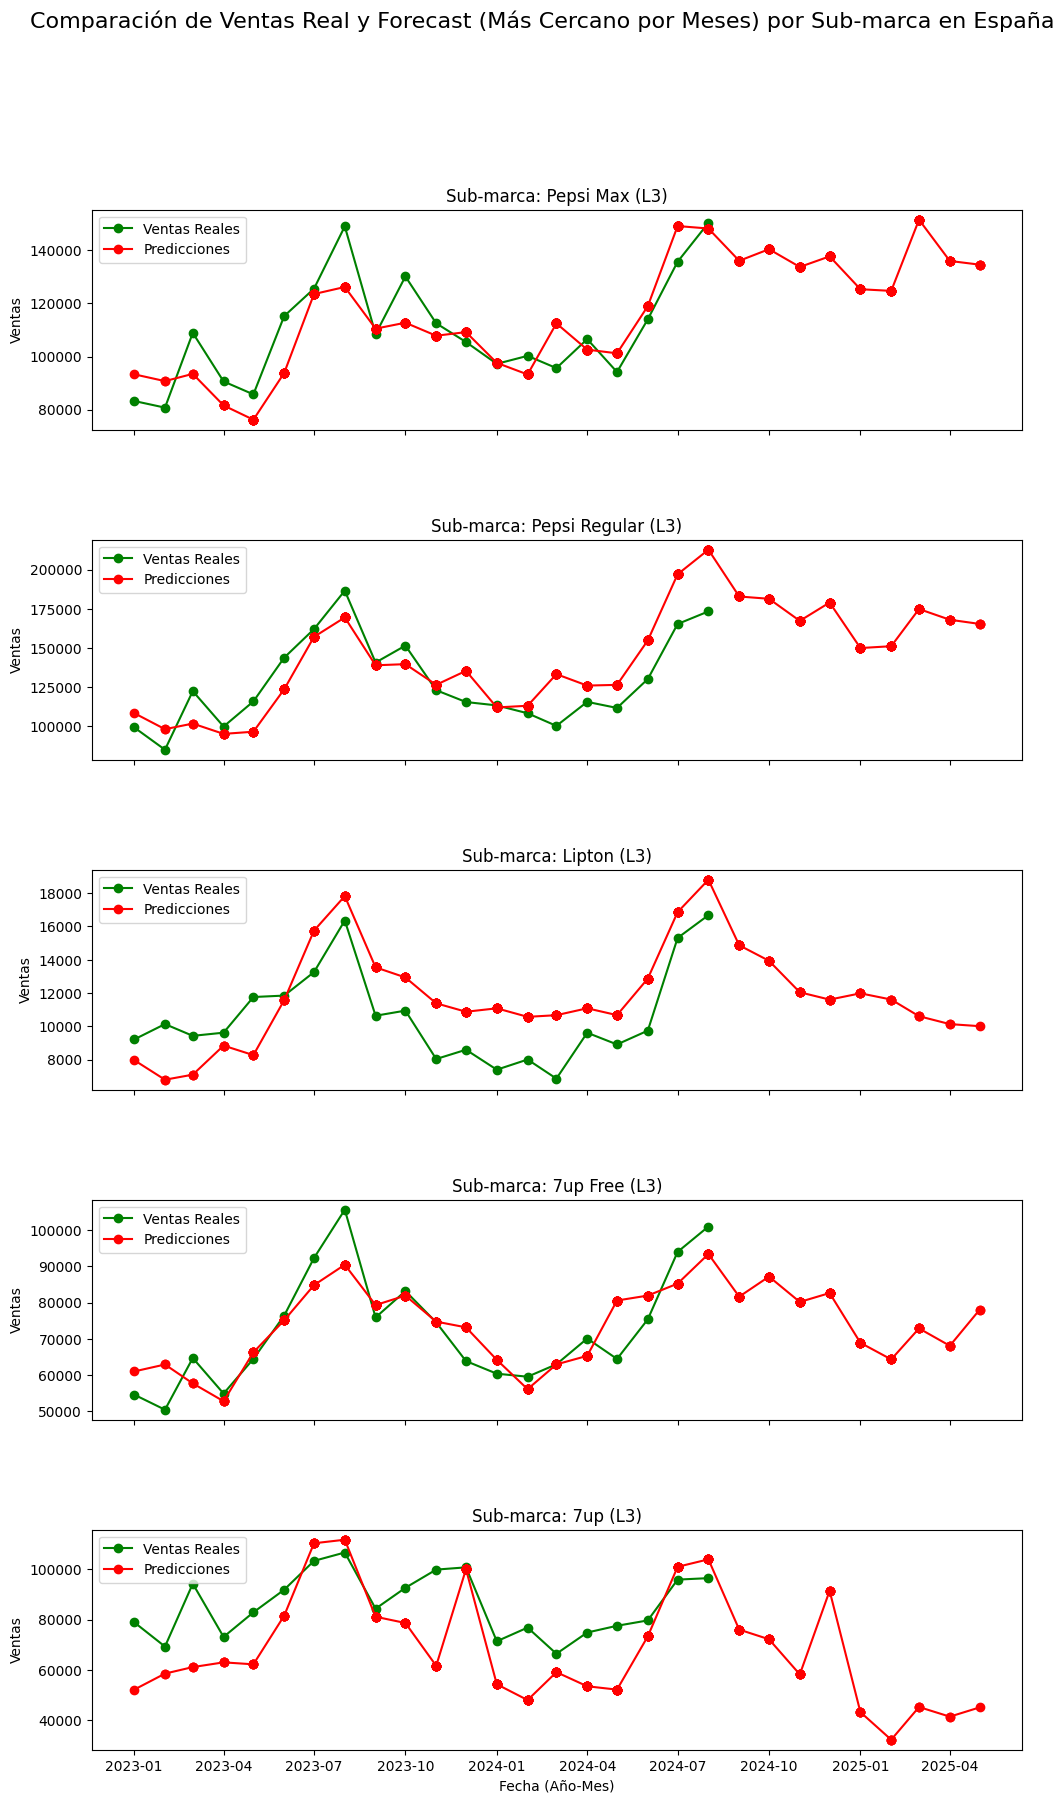

In [139]:
# Filtrar los datos de valores reales y predicciones para España
actuals = df[df['SCENARIO'] == 'actual']
forecast = df[df['SCENARIO'] == 'AI_forecast']

# Crear subplots para cada sub-marca
subbrands = df['SUBBRAND'].unique()
num_subplots = len(subbrands)
fig, axes = plt.subplots(num_subplots, 1, figsize=(12, 4 * num_subplots), sharex=True)
fig.suptitle('Comparación de Ventas Real y Forecast (Más Cercano por Meses) por Sub-marca en España', fontsize=16)
fig.subplots_adjust(hspace=0.5)

# Generar cada subplot para cada sub-marca
for i, subbrand in enumerate(subbrands):
    ax = axes[i] if num_subplots > 1 else axes

    # Filtrar datos por sub-marca y ordenar por fecha
    actuals_subbrand = actuals[actuals['SUBBRAND'] == subbrand].sort_values('PERIODO')
    forecast_subbrand = forecast[forecast['SUBBRAND'] == subbrand].sort_values('PERIODO')

    # Graficar los valores reales (actuals) en verde con línea
    ax.plot(actuals_subbrand['PERIODO'], actuals_subbrand['AMOUNT'], color='green', label='Ventas Reales', linestyle='-', marker='o')

    # Graficar los valores de predicción más cercanos (forecast) en rojo con línea
    ax.plot(forecast_subbrand['PERIODO'], forecast_subbrand['CLOSEST_FORECAST'], color='red', label='Predicciones', linestyle='-', marker='o')

    # Configurar el subplot
    ax.set_title(f'Sub-marca: {subbrand}')
    ax.set_ylabel('Ventas')
    ax.set_facecolor('white')  # Fondo blanco
    ax.legend(loc='upper left')

# Configuración general del gráfico
axes[-1].set_xlabel('Fecha (Año-Mes)')
plt.grid(False)  # Sin cuadrícula
plt.show()


Aqui podemos ver representado los forecast y los actuals y vemos que mas o menos se acercan por lo que da una buena impresion de cara a fiarse de las predicciones. De todas formas vamos a calcular los errores.

In [140]:
actuals = df[df['SCENARIO'] == 'actual'][['PERIODO', 'SUBBRAND', 'AMOUNT']].rename(columns={'AMOUNT': 'ACTUAL'})
forecast = df[df['SCENARIO'] == 'AI_forecast'][['PERIODO', 'SUBBRAND', 'CLOSEST_FORECAST']].rename(columns={'CLOSEST_FORECAST': 'FORECAST'})

# Unimos los datos de actuals y forecast para comparación
comparison_df = pd.merge(actuals, forecast, on=['PERIODO', 'SUBBRAND'])

# Calculamos los errores
comparison_df['ERROR'] = comparison_df['ACTUAL'] - comparison_df['FORECAST']
comparison_df['ABSOLUTE_ERROR'] = comparison_df['ERROR'].abs()
comparison_df['SQUARED_ERROR'] = comparison_df['ERROR'] ** 2
comparison_df['PERCENTAGE_ERROR'] = (comparison_df['ABSOLUTE_ERROR'] / comparison_df['ACTUAL']).replace([np.inf, -np.inf], np.nan) * 100

# Calculamos métricas de precisión
mae = comparison_df['ABSOLUTE_ERROR'].mean()
mse = comparison_df['SQUARED_ERROR'].mean()
rmse = np.sqrt(mse)
mape = comparison_df['PERCENTAGE_ERROR'].mean()

# Mostramos resultados
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Error (MAE): 9869.032931387272
Mean Squared Error (MSE): 188593937.06479523
Root Mean Squared Error (RMSE): 13732.950777775155
Mean Absolute Percentage Error (MAPE): 11.820650765299224%


El error final es de un 11 por ciento por lo que no es del todo malo pero se podria mejorar las predicciones. Nos sirve para tener una aproximacion fiable.